In [355]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, pyplot, transforms
from matplotlib.collections import LineCollection
import seaborn as sns
import pandas as pd
import math
import pickle
import time
import random

In [7]:
orders = pd.read_csv('data/orders.csv').astype({'#ORDER_ID': str, ' SKU': str})
orders, orders.dtypes

(    #ORDER_ID      SKU   AMOUNT
 0           1  1579172        6
 1           2  2609314       12
 2           3  1335852       53
 3           4  1748526        5
 4           5  1332937        2
 ..        ...      ...      ...
 670       671  2201629        5
 671       672   548501       11
 672       673  2201629        1
 673       674   548501       11
 674       675   548501        2
 
 [675 rows x 3 columns],
 #ORDER_ID    object
  SKU         object
  AMOUNT       int64
 dtype: object)

In [8]:
mapp = pd.read_csv('data/map.csv', skiprows=[1]).astype({'#TYPE': str}).fillna('')
mapp, mapp.dtypes, max(mapp[' X']), max(mapp[' Y'])

(    #TYPE   X   Y    NEIGHBORS
 0       1   3   0  3:1;2:0;4:0
 1       1   4   0  4:1;3:0;5:0
 2       1   5   0      5:1;4:0
 3       1   6   0          6:1
 4       5   7   0          7:1
 ..    ...  ..  ..          ...
 699     6   0  17         1:17
 700     6   0  18         1:18
 701     1   0  19         1:19
 702     1   0  20         1:20
 703     1   0  21             
 
 [704 rows x 4 columns],
 #TYPE         object
  X             int64
  Y             int64
  NEIGHBORS    object
 dtype: object,
 31,
 21)

In [9]:
pallets = pd.read_csv('data/pallets.csv').astype({' PALLET_ID': str})
pallets, pallets.dtypes

(                  #SKU_QUANTITY_LIST   X   Y  PALLET_ID
 0       104151:9,840211:35,1297235:1  18   8      10000
 1    901897:13,1297235:18,2171945:14  19  16      10001
 2                          653296:69  14  12      10002
 3                         1473101:66  18  15      10003
 4                961380:8,1187577:49  14   6      10004
 ..                               ...  ..  ..        ...
 143            1751060:20,2247923:14  24  15      10143
 144             582599:33,1766481:54  13   5      10144
 145             2302238:2,1867146:34  12   6      10145
 146             1286521:31,901902:24  12  13      10146
 147             1308094:52,1085002:4   9  12      10147
 
 [148 rows x 4 columns],
 #SKU_QUANTITY_LIST    object
  X                     int64
  Y                     int64
  PALLET_ID            object
 dtype: object)

In [10]:
sku2palletID = dict()
q = dict()  # 托盘p包含商品c的数量
for i, row in pallets.iterrows():
    sku_quantity_list, x, y, pallet_id = row
    # print(sku_quantity_list, x, y, pallet_id)
    
    # process sku_quantity_list
    sku_quantity_list = sku_quantity_list.split(',')  # e.g. ['104151:9', '840211:35', '1297235:1']
    temp = dict()
    for sq_str in sku_quantity_list:  # sq_str like '104151:9'
        sku, quantity = sq_str.split(':')
        temp[sku] = int(quantity)
        
        temp2 = sku2palletID.get(sku, [])
        temp2.append((pallet_id, quantity))
        sku2palletID[sku] = temp2
    q[pallet_id] = temp
print(q['10000'])
sku2palletID['104151'], len(sku2palletID['104151'])

{'104151': 9, '840211': 35, '1297235': 1}


([('10000', '9'), ('10027', '27')], 2)

In [11]:
C = set()  # 商品集合, set of length 181
for _ in q.values():  # _ like {'104151': 9, '840211': 35, '1297235': 1}
    for sku in _:
        C.add(sku)

In [240]:
class Pallet:
    def __init__(self, sku_quantity_list, x, y, pallet_id):
        """
        @param sku_quantity_list: str, e.g. '104151:9,840211:35,1297235:1'
        @param x: int64
        @param y: int64
        @param pallet_id: str, e.g. '10000'
        """
        self.sku_quantity = {}
        self.capacity = 0
        for sku_quantity in sku_quantity_list.split(','):
            sku, quantity = sku_quantity.split(':')
            self.sku_quantity[sku] = int(quantity)
            self.capacity += int(quantity)
        self.pos = (x, y)
        self.id = pallet_id
        self.carriedBy = None
        
    def print(self):
        print('Pallet id: {}, pos: {}, sku_quantity: {}, capacity: {}, carriedBy: {}'.format(
            self.id, self.pos, self.sku_quantity, self.capacity, self.carriedBy
        ))
temp = Pallet(pallets.loc[0, '#SKU_QUANTITY_LIST'], 
              pallets.loc[0, ' X'], 
              pallets.loc[0, ' Y'], 
              pallets.loc[0, ' PALLET_ID'])
temp.print()

Pallet id: 10000, pos: (18, 8), sku_quantity: {'104151': 9, '840211': 35, '1297235': 1}, capacity: 45, carriedBy: None


In [121]:
agv = pd.read_csv('data/agv.csv').astype({'#AGV_ID': str})
agv, agv.dtypes

(   #AGV_ID   X   Y
 0        1  31  14
 1        2  26  11
 2        3  29  16
 3        4   5   7
 4        5  27  18
 5        6  22  10
 6        7   9  20
 7        8  14  17
 8        9   8  11
 9       10  19  18
 10      11  25   6
 11      12   9   7
 12      13  11  16
 13      14  17   8
 14      15   0   5
 15      16   3  16
 16      17  24  15
 17      18  20   4
 18      19   4   0
 19      20   1  14,
 #AGV_ID    object
 X           int64
 Y           int64
 dtype: object)

In [225]:
def action2pos(curr_pos, action):
    """
    @param curr_pos: (x, y)
    @param curr_pos: 0: stop, 1: up, 2: down, 3: left, 4: right
    """
    temp = {0: (x, y), 1: (x - 1, y), 2: (x + 1, y), 3: (x, y - 1), 4: (x, y+ 1)}
    return temp[action]

In [233]:
class AGV:
    def __init__(self, agv_id, x, y, tp):
        """
        @param agv_id: str, e.g. '1'
        @param x: int64
        @param y: int64
        """
        self.id = agv_id
        self.pos = (x, y)
        self.tp = tp
        self.carrying = False
    def print(self):
        tp_dict = {1: '路径', 2: '储位', 3: '保留', 4: '柱子', 5: '拣选工位', 6: '补货位', 7: '空托盘回收'}
        print('AGV id: {}, pos: {}, tp: {}, carrying: {}'.format(
            self.id, self.pos, tp_dict[self.tp], self.carrying
        ))
temp = AGV(agv.loc[0, '#AGV_ID'], agv.loc[0, 'X'], agv.loc[0, 'Y'], 1)
temp.print()

AGV id: 1, pos: (31, 14), tp: 路径, carrying: False


In [390]:
class Board:
    def __init__(self, mapp, pallets, agv, orders):
        # process mapp, create tp_array, nbr_array
        x_lim, y_lim = max(mapp[' X']) + 1, max(mapp[' Y']) + 1
        self.tp_array = -1 * np.ones([x_lim, y_lim], dtype=int)
        self.nbr_array = np.empty([x_lim, y_lim], dtype=object)
        self.walls = []
        for i, row in mapp.iterrows():
            tp, x, y, raw_nbrs = row
            self.tp_array[x, y] = tp
            #print(type(raw_nbrs), raw_nbrs)
            if raw_nbrs:
                raw_nbrs = {_ for _ in raw_nbrs.split(';')}  # e.g. {'2:0', '3:1', '4:0'}
                nbrs = set()
                for nbr in raw_nbrs:
                    ux, uy = nbr.split(':')
                    nbrs.add((int(ux), int(uy)))
                self.nbr_array[x, y] = nbrs  # e.g. {(1, 1), (0, 2), (1, 3), (2, 2)}
            else:
                self.nbr_array[x, y] = set()
            all_nbrs = {(x, y + 1), (x, y - 1), (x - 1, y), (x + 1, y)}
            for nbr in all_nbrs - self.nbr_array[x, y]:
                nx, ny = nbr
                if x == nx:  # y should be substracted by y_limit - 1
                    self.walls.append([((y + ny) / 2, x + 0.5), ((y + ny) / 2, x - 0.5)])
                elif y == ny:
                    self.walls.append([(y + 0.5, (x + nx) / 2), (y - 0.5, (x + nx) / 2)])
                else:
                    assert False, 'x: {}, y:{}, nbrs: {}'.format(x, y, nbrs)
        # process pallets
        self.pallets = dict()
        self.pos2palletID = np.empty([x_lim, y_lim], dtype=object)
        for i, row in pallets.iterrows():
            sku_quantity_list, x, y, pallet_id = row
            self.pallets[pallet_id] = Pallet(sku_quantity_list, x, y, pallet_id)
            self.pos2palletID[x, y] = pallet_id
        # process agv
        self.agvs = dict()
        for i, row in agv.iterrows():
            agv_id, x, y = row
            self.agvs[agv_id] = AGV(agv_id, x, y, self.tp_array[x, y])
        # process orders
        self.sku_needed = dict()
        for i, row in orders.iterrows():
            order_id, sku, amount = row
            sku_amount = self.sku_needed.get(sku, 0)
            sku_amount += amount
            self.sku_needed[sku] = sku_amount
            
    def plot(self):
        fig, ax = plt.subplots(figsize=(16, 11))
        plt.axis('off')
        # plot map
        cmap = colors.ListedColormap(['lightgray', 'green', 'yellow', 'black', 'blue', 'pink', 'red'])
        bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        ax.imshow(board.tp_array, cmap=cmap, norm=norm)
        # plot walls
        lc = LineCollection(self.walls, colors=['black'] * len(self.walls), alpha=0.5)
        ax.add_collection(lc)
        # plot agvs
        # plt.scatter([agv.pos[1] for agv in self.agvs.values()], 
        #             [agv.pos[0] for agv in self.agvs.values()], 
        #             color='tab:orange', label='AGV', s=200)
        # plot pallets
#         plt.scatter([pallet.pos[1] for pallet in self.pallets.values()], 
#                     [pallet.pos[0] for pallet in self.pallets.values()], 
#                     color='white', label='AGV', s=70)
#         for pallet in self.pallets.values():
#             x, y = pallet.pos
#             sku_quantity = pallet.sku_quantity
#             for skuID in sku_quantity.keys():
#                 if skuID in self.sku_needed.keys():  # if there still exists needed sku
#                     pallet_color = 'darkgreen'
#                     break
#             else:
#                 pallet_color = 'black'
#             loading_rate = sum(pallet.sku_quantity.values()) / pallet.capacity
#             # plt.text(y, x, str(round(loading_rate, 1)), color=pallet_color, ha='center', va='center', size=6)
        
        # plot for question 2
        # W = [(8, 0), (20, 0), (31, 7), (31, 15), (8, 21), (20, 21)] # (x, y)
        # W_color = {(8, 0): 'purple', (20, 0): 'brown', (31, 7): 'olive', 
        #            (31, 15): 'cyan', (8, 21): 'white', (20, 21): 'darkcyan'}
        # for (x, y), color in W_color.items():
        #     plt.scatter(y, x, color=color)
        # for palletID, pos in palletID2pos:
        #     x, y = self.pallets[palletID].pos
        #     plt.scatter(y, x, color=W_color[pos])
        
        # plot for m8 mtsp
#         pos2route = m8_mtsp_bs14_b0['pos2route']
#         get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
#         color_cycle = get_colors(len(pos2route))
#         for i, positions in enumerate(pos2route.values()):
#             temp = np.array(positions)
#             color = color_cycle[i]
#             for _ in range(len(temp) - 1):
#                 x1, y1 = temp[_]
#                 x2, y2 = temp[_ + 1]
#                 ax.quiver(y1, x1, y2 - y1, x2 - x1, scale_units='xy', angles='xy', scale=1, color=color)
                
#             plt.scatter(positions[0][1], positions[0][0], color=color, label='AGV', s=200)
        for pallet_id in self.pallets.keys() - {'10069', '10142', '10143', '10146', '10147'}:
            
    
        plt.savefig('images/board-{}.png'.format(time.strftime('%Y%m%d-%H%M%S')), bbox_inches='tight')
    
    def step(self, action_dict, priority_list):
        """
        @param action_dict: e.g. {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, ...}
        @param priority_list: e.g. ['10', '0', ...] means agv 10 is handled in front of agn 0
        """
        assert len(actions_dict) == len(priority_list) == len(self.agvs)
        next_positions = dict()
        for agvID in priority_list:
            action = action_dict[agvID]
            agv = self.agvs[agvID]
            x, y = agv.pos
            tx, ty = action2pos((x, y), action)
            nbr = self.nbr_array[x, y]  # e.g. {(0, 0), (0, 2), (1, 1)}
            tp = agv.tp  # in case temp has pallet and agv carrying pallet, agv can not move!
            ttp = self.tp_array[tx, ty]
            pallet_id = self.pos2palletID[tx, ty]  # None or pallet ID
            if (tx, ty) not in nbr or \
                (tx, ty) in next_positions.values() or \
                tp in (1, 3, 6) and ttp == 2 and agv.carrying and pallet_id:  # if blocked by wall or occupied or meet pallet
                next_positions[agvID] = (x, y)  # do not move
            else:  # not blocked by walls and not occupied
                next_positions[agvID] = (tx, ty)
                if tp in (1, 3, 6):  # 路径(灰色), 保留(黄色), 补货(粉色)
                    if ttp == 2 :  # 储位(绿色)
                        if not agv.carrying and pallet_id:
                            self.agvs[agvID].carrying = True
                            self.pallets[pallet_id].carriedBy = agvID
                        
                    elif ttp == 5:  # 拣选(蓝色)
                        pass
                    elif ttp == 7:  # 空托盘回收(红色)
                        pass
                    else:
                        assert ttp == 1  # 路径(灰色)
                self.agvs[agvID].pos = (tx, ty)
                self.agvs[agvID].tp = ttp
            
            
        
board = Board(mapp, pallets, agv, orders)
# board.tp_array, board.nbr_array

In [391]:
board.nbr_array[0, 1]

{(0, 0), (0, 2), (1, 1)}

In [392]:
board.pallets['10000'].print()

Pallet id: 10000, pos: (18, 8), sku_quantity: {'104151': 9, '840211': 35, '1297235': 1}, capacity: 45, carriedBy: None


In [393]:
board.agvs['1'].print()

AGV id: 1, pos: (31, 14), tp: 拣选工位, carrying: False


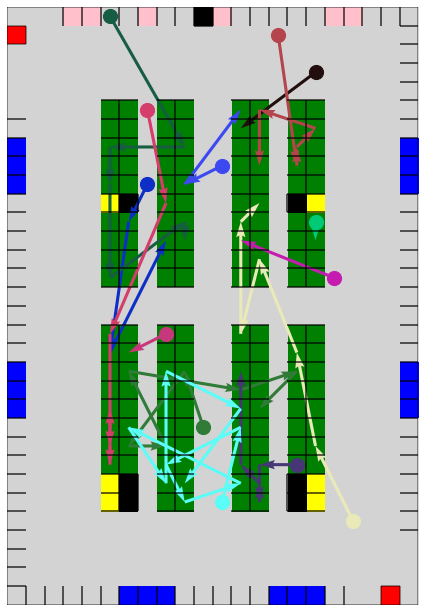

In [ ]:
board.plot()

In [389]:
with open('save/palletID2pos.pickle', 'rb') as handle:
    palletID2pos = pickle.load(handle)

In [327]:
with open('save/m8-mtsp-bs14-b0.pickle', 'rb') as handle:
    m8_mtsp_bs14_b0 = pickle.load(handle)
m8_mtsp_bs14_b0, np.array(m8_mtsp_bs14_b0['pos2route']['5'])

({'pos2route': {'5': [(27, 18),
    (23, 16),
    (18, 15),
    (13, 13),
    (17, 12),
    (11, 12),
    (10, 13)],
   '9': [(8, 11), (9, 9), (5, 12)],
   '8': [(14, 17), (12, 12)],
   '6': [(22, 10),
    (19, 9),
    (23, 6),
    (23, 8),
    (19, 6),
    (20, 12),
    (19, 15),
    (21, 13)],
   '12': [(9, 7), (11, 6), (18, 5), (12, 8)],
   '14': [(17, 8), (18, 6)],
   '16': [(3, 16), (6, 12)],
   '15': [(0, 5), (7, 9), (7, 5), (9, 5), (14, 5), (11, 9), (12, 9)],
   '17': [(24, 15), (24, 13), (26, 13), (25, 13), (24, 12), (19, 12)],
   '4': [(5, 7), (10, 8), (17, 5), (23, 5), (24, 5), (21, 5)],
   '13': [(11, 16), (12, 16)],
   '20': [(1, 14), (8, 15), (7, 15), (6, 16), (5, 13), (8, 13)],
   '2': [(26, 11),
    (22, 12),
    (24, 8),
    (26, 9),
    (25, 12),
    (22, 6),
    (25, 8),
    (19, 8),
    (21, 12),
    (25, 9)]},
  'objVal': 1191.0},
 array([[27, 18],
        [23, 16],
        [18, 15],
        [13, 13],
        [17, 12],
        [11, 12],
        [10, 13]]))